TRANSFER LEARNING


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os

c:\Users\euge.UPCONT\Miniconda3\envs\DL-TORCH\lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Definición del modelo

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = torch.nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            #nn.MaxPool2d((2, 2)),
            nn.Flatten(),
            nn.Linear(64*14*14, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        out = self.main(x)
        return out


Recupera el modelo a reutilizar

In [3]:
# Para recuperar un modelo
nombre_modelo_cnn = 'modelo_cnn_ajustado_2_epocas.pth'

# crea una instancia del modelo
model = CNN()

# carga en el modelo los pesos ajustados
model.load_state_dict(torch.load(nombre_modelo_cnn))

# modelo
model

# asegura modo evaluación
model.eval()

CNN(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=12544, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=10, bias=True)
  )
)

### Preparamos los datos y la carga del nuevo dataset

In [4]:
# Asegura que la imagen es de 28x28 píxeles, un único canal y normalizada ??
transforma_img = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Lambda(lambda x: transforms.functional.invert(x)),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5],std=[0.5])
])

In [5]:
# define los datasets 
dir_imgs_ESU23 = os.path.join('data','ESU23')

tr_dataset = datasets.ImageFolder(os.path.join(dir_imgs_ESU23, 'TR'), transform = transforma_img)
ts_dataset = datasets.ImageFolder(os.path.join(dir_imgs_ESU23, 'TS'), transform = transforma_img)

print(tr_dataset)
print(ts_dataset)
categorias = tr_dataset.classes
print(f'Categorías de salida: {categorias}')

# crea los cargadores de datos
num_lotes = 100
train_loader = torch.utils.data.DataLoader(dataset=tr_dataset, 
                                           batch_size = num_lotes,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset=ts_dataset, 
                                           batch_size = num_lotes,
                                           shuffle = False)


Dataset ImageFolder
    Number of datapoints: 18830
    Root location: data\ESU23\TR
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Lambda()
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 3150
    Root location: data\ESU23\TS
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Lambda()
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )
Categorías de salida: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


Tensor con el lote: torch.Size([100, 1, 28, 28])
Nº etiquetas del lote: torch.Size([100])


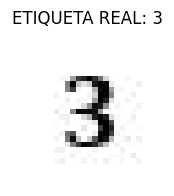

In [58]:

train_imgs, train_labels = next(iter(train_loader))
print(f"Tensor con el lote: {train_imgs.size()}")
print(f"Nº etiquetas del lote: {train_labels.size()}")

fig = plt.figure(1,figsize=(2, 2))
plt.imshow(train_imgs[0].squeeze(), cmap=plt.cm.binary)
plt.title(f'ETIQUETA REAL: {train_labels[0]}')
plt.axis('off')
plt.show()

In [175]:
# CPU o GPU
device = torch.device('cpu')


In [176]:
# entrenamiento
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for imgs, etqs in train_loader:
        imgs = imgs.to(device)
        etqs = etqs.to(device)  
        outputs = model(imgs)

        _, predictions = torch.max(outputs, 1)
        n_samples += etqs.shape[0] 
        n_correct += (predictions == etqs).sum().item()

    acc = 100.0 * n_correct / n_samples
    n_incorrect = n_samples - n_correct

    print(f'Correctas:{n_correct} Incorrectas:{n_incorrect}')
    print(f'Aciertos TR: {acc}')


# test
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for imgs, etqs in test_loader:
        imgs = imgs.to(device)
        etqs = etqs.to(device)  
        outputs = model(imgs)

        _, predictions = torch.max(outputs, 1)
        n_samples += etqs.shape[0] 
        n_correct += (predictions == etqs).sum().item()

    acc = 100.0 * n_correct / n_samples
    n_incorrect = n_samples - n_correct

    print(f'Correctas:{n_correct} Incorrectas:{n_incorrect}')
    print(f'Aciertos TS: {acc}')


Correctas:14647 Incorrectas:4183
Aciertos TR: 77.78544875199151
Correctas:2520 Incorrectas:630
Aciertos TS: 80.0


3150.0


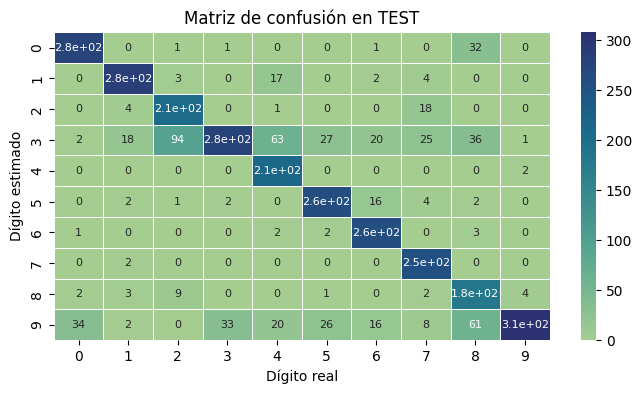

In [177]:
# matriz de confusión TEST
confusion_matrix = torch.zeros(10, 10, dtype=float)
with torch.no_grad():
    for i, (imgs, etqs) in enumerate(test_loader):
        imgs = imgs.to(device)
        etqs = etqs.to(device)  
        outputs = model(imgs)
        _, predictions = torch.max(outputs, 1)

        for t, p in zip(etqs.view(-1), predictions.view(-1)):
            confusion_matrix[p.long(), t.long()] += 1

# eliminamos los aciertos para facilitar el foco en los errores de clasificación
#confusion_matrix[confusion_matrix>100] = float("nan")

print(confusion_matrix.nansum().item())

# representamos para facilitar el análisis
fig = plt.figure(1,figsize=(8, 4))
sns.heatmap(confusion_matrix, annot=True, linewidth=.5,  cmap="crest", annot_kws={"fontsize":8})
plt.title('Matriz de confusión en TEST')
plt.xlabel('Dígito real')
plt.ylabel('Dígito estimado')
plt.show()


### Reajuste de la CNN para adaptarla al nuevo problema (transfer learning)

https://www.tomasbeuzen.com/deep-learning-with-pytorch/chapters/chapter6_cnns-pt2.html#transfer-learning

In [178]:
model

CNN(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=12544, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [179]:
# Freeze parameters so we don't update them
CONGELAR = False
if CONGELAR:
    lista_componentes_congelar = range(5)
    for c in lista_componentes_congelar:
        comp = model.main[c]
        for param in comp.parameters():  
            param.requires_grad = False


In [180]:

# cambia el clasificador final por uno nuevo   
model.main[6] = nn.Linear(64*14*14, 120)
model.main[7] = nn.ReLU()
model.main[8] = nn.Linear(120, 10)


reajusta

In [181]:

# función de pérdida, ratio de aprendizaje y optimizador
funcion_perdida = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizador = torch.optim.Adam(model.parameters(), lr = learning_rate)

# nº de épocas
n_epochs = 2

In [182]:
# asegura modo training
model.train()

# Bucle de ajuste de los parámetros del modelo
n_total_steps = len(train_loader)
tr_eval_loss = np.zeros(n_epochs * n_total_steps)

k=0
for epoch in range(n_epochs):
    for i, (imgs, etqs) in enumerate(train_loader):
        imgs = imgs.to(device)
        etqs = etqs.to(device)
        
        # forward
        outputs = model(imgs)
        loss = funcion_perdida(outputs, etqs)
        tr_eval_loss[k] = loss
        k+=1

        # backwards
        optimizador.zero_grad()
        loss.backward()
        optimizador.step()

        if (i+1) % 50 == 0:
            print(f'Época: {epoch+1}/{n_total_steps} '
                  f' - Paso: {i+1}/{n_total_steps} :: loss = {loss.item()}')
            
# pone modo evaluación
model.eval()

Época: 1/189  - Paso: 50/189 :: loss = 0.07778439670801163
Época: 1/189  - Paso: 100/189 :: loss = 0.1740952879190445
Época: 1/189  - Paso: 150/189 :: loss = 0.055797871202230453
Época: 2/189  - Paso: 50/189 :: loss = 0.015021643601357937
Época: 2/189  - Paso: 100/189 :: loss = 0.017245877534151077
Época: 2/189  - Paso: 150/189 :: loss = 0.013302650302648544


CNN(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=12544, out_features=120, bias=True)
    (7): ReLU()
    (8): Linear(in_features=120, out_features=10, bias=True)
  )
)

Correctas:18572 Incorrectas:258
Aciertos TR: 98.62984599044078
Correctas:3072 Incorrectas:78
Aciertos TS: 97.52380952380952
3150.0


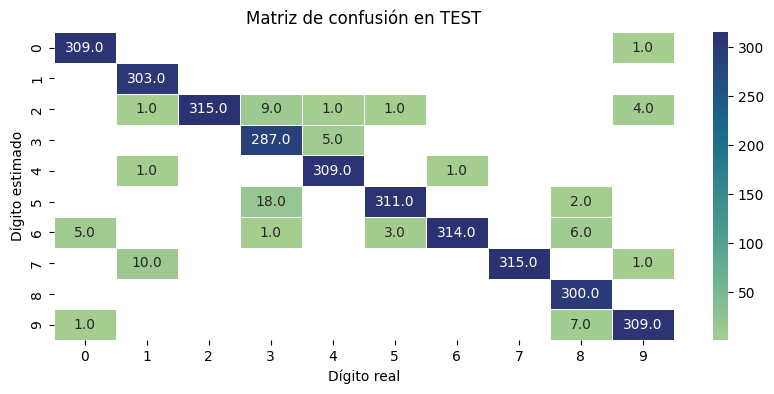

In [183]:
# entrenamiento
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for imgs, etqs in train_loader:
        imgs = imgs.to(device)
        etqs = etqs.to(device)  
        outputs = model(imgs)

        _, predictions = torch.max(outputs, 1)
        n_samples += etqs.shape[0] 
        n_correct += (predictions == etqs).sum().item()

    acc = 100.0 * n_correct / n_samples
    n_incorrect = n_samples - n_correct

    print(f'Correctas:{n_correct} Incorrectas:{n_incorrect}')
    print(f'Aciertos TR: {acc}')


# test
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for imgs, etqs in test_loader:
        imgs = imgs.to(device)
        etqs = etqs.to(device)  
        outputs = model(imgs)

        _, predictions = torch.max(outputs, 1)
        n_samples += etqs.shape[0] 
        n_correct += (predictions == etqs).sum().item()

    acc = 100.0 * n_correct / n_samples
    n_incorrect = n_samples - n_correct

    print(f'Correctas:{n_correct} Incorrectas:{n_incorrect}')
    print(f'Aciertos TS: {acc}')

# matriz de confusión TEST
confusion_matrix = torch.zeros(10, 10, dtype=float)
with torch.no_grad():
    for i, (imgs, etqs) in enumerate(test_loader):
        imgs = imgs.to(device)
        etqs = etqs.to(device)  
        outputs = model(imgs)
        _, predictions = torch.max(outputs, 1)

        for t, p in zip(etqs.view(-1), predictions.view(-1)):
            confusion_matrix[p.long(), t.long()] += 1

# eliminamos los ceros para facilitar el foco en los errores de clasificación
confusion_matrix[confusion_matrix==0] = float("nan")

print(confusion_matrix.nansum().item())

# representamos para facilitar el análisis
fig = plt.figure(1,figsize=(10, 4))
sns.heatmap(confusion_matrix, annot=True, linewidth=.5,  cmap="crest", fmt='1.1f')
plt.title('Matriz de confusión en TEST')
plt.xlabel('Dígito real')
plt.ylabel('Dígito estimado')
plt.show()


In [184]:
# guardamos en un nuevo tensor todos los casos incorrectos
tr_err_img = torch.empty(1, 1, 28, 28, dtype=float)
tr_err_etq_real = torch.empty(1, 1, dtype=torch.uint8)
tr_err_etq_est = torch.empty(1, 1, dtype=torch.uint8)

with torch.no_grad():
    for i, (imgs, etqs) in enumerate(test_loader):
        imgs = imgs.to(device)
        etqs = etqs.to(device)  
        outputs = model(imgs)
        _, predictions = torch.max(outputs, 1)

        # cogemos los fallos
        ind_fallos = etqs != predictions

        tr_err_img = torch.cat((tr_err_img, imgs[ind_fallos]), dim=0)
        tr_err_etq_real = torch.cat((tr_err_etq_real, etqs[ind_fallos].unsqueeze(0)), dim=1)
        tr_err_etq_est = torch.cat((tr_err_etq_est, predictions[ind_fallos].unsqueeze(0)), dim=1)
        # print(tr_err_etq_real)
        # print(tr_err_etq_est)
        # print(tr_err_img)

print(tr_err_etq_real.size())
print(tr_err_etq_est.size())
print(tr_err_img.size())

torch.Size([1, 79])
torch.Size([1, 79])
torch.Size([79, 1, 28, 28])


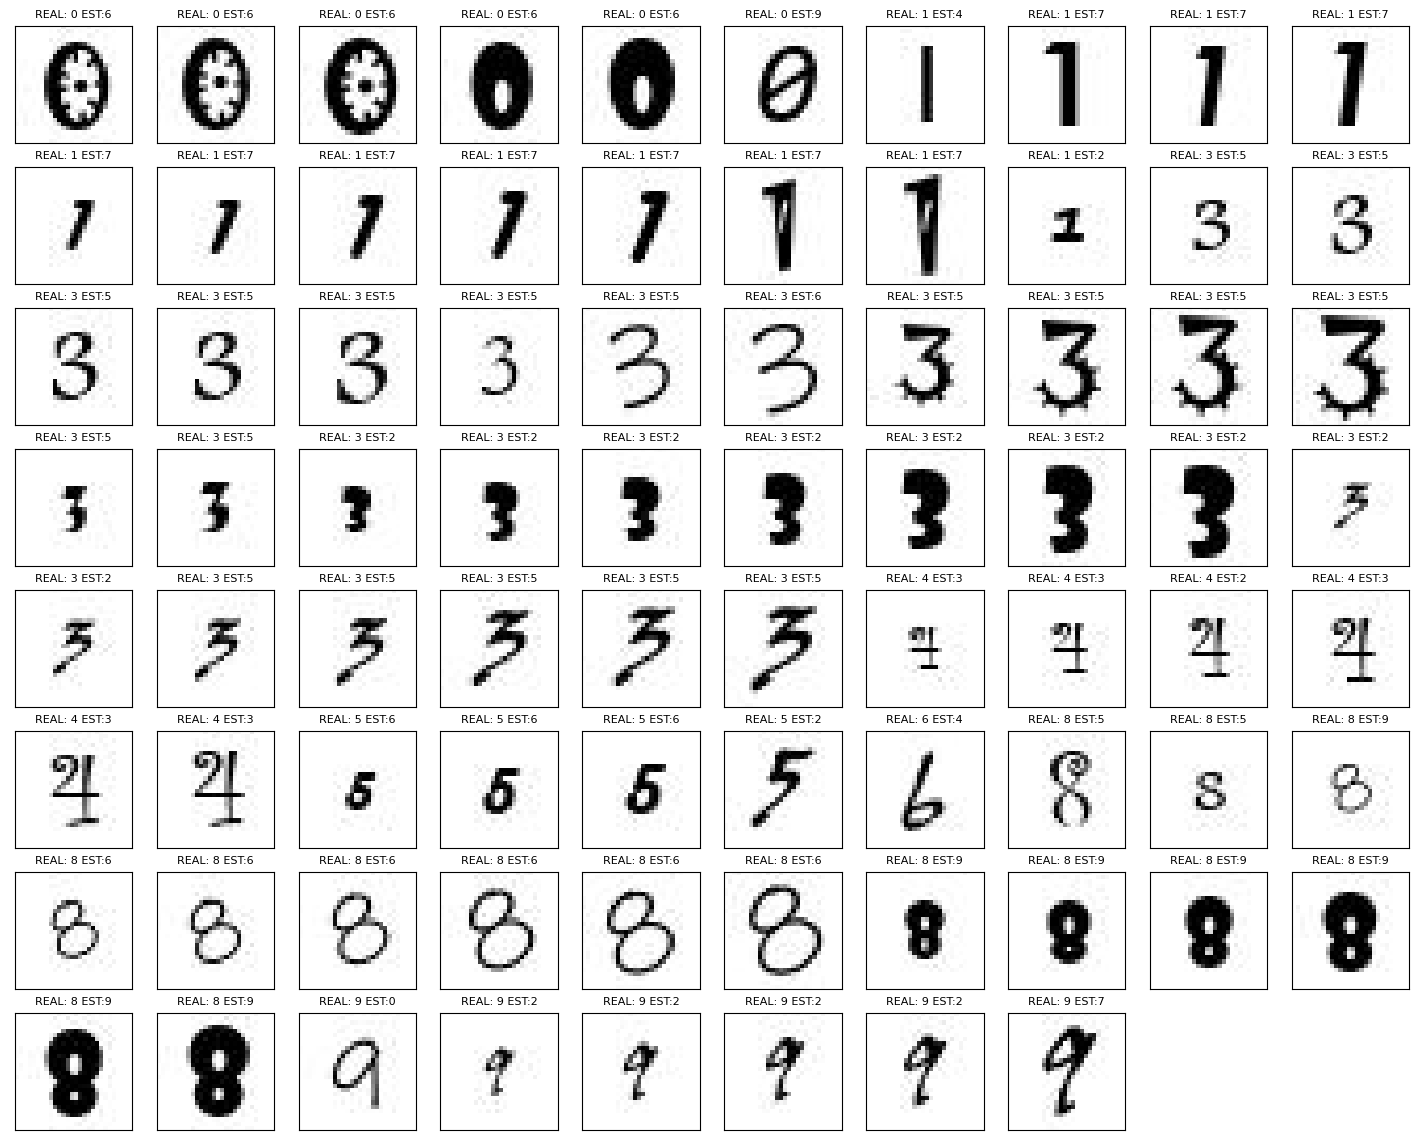

In [185]:
# pintamos unos cuantos fallos
fig = plt.figure(1,figsize=(18, 18))
k=1
for i in range(tr_err_etq_est.size(1)-1):
    plt.subplot(10,10,k)
    plt.imshow(tr_err_img[i+1].reshape(28,28), cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
    plt.title(f'REAL: {tr_err_etq_real[0,i+1].item()} EST:{tr_err_etq_est[0,i+1].item()}',fontdict={'size': 8})
    k = k+1

plt.show()

saliency map

In [1]:
# imagen para analizar (en carpeta PRU)
ruta_img_pru = os.path.join(dir_imgs_ESU23, 'PRU')
print(ruta_img_pru)
pru_dataset = datasets.ImageFolder(ruta_img_pru, transform = transforma_img)
pru_loader = torch.utils.data.DataLoader(dataset=pru_dataset, batch_size = 1, shuffle = True)

# recupera la imagen
pru_img, pru_label = next(iter(pru_loader))

fig = plt.figure(1,figsize=(2, 2))
plt.imshow(pru_img[0].squeeze(), cmap=plt.cm.binary)
plt.axis('off')
plt.show()

NameError: name 'os' is not defined

tensor([[-8.8322,  2.1753,  7.1228,  8.2980,  4.3831, -0.2099, -7.9136, -0.7438,
          0.4860,  0.4119]], grad_fn=<AddmmBackward0>)


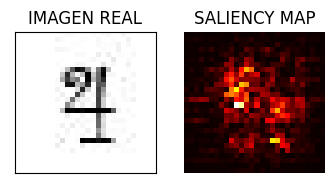

In [187]:
pru_img.requires_grad_()
pru_img = pru_img.to(device)

# pone en modo evaluación para desactivar dropout 
model.eval()

'''
forward pass through the model to get the scores, note that VGG-19 model doesn't perform softmax at the end
and we also don't need softmax, we need scores, so that's perfect for us.
'''
scores = model(pru_img)
print(scores)

# Get the index corresponding to the maximum score and the maximum score itself.
score_max_index = scores.argmax()
score_max = scores[0,score_max_index]

# forzando la salida a derivar
#score_max = scores[0,4]


'''
backward function on score_max performs the backward pass in the computation graph and calculates the gradient of 
score_max with respect to nodes in the computation graph
'''
score_max.backward()

'''
Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
across all colour channels.
'''
saliency, _ = torch.max(pru_img.grad.data.abs(),dim=1)

# plot the saliency map as a heatmap
with torch.no_grad(): 
    fig = plt.figure(1,figsize=(4, 4))
    plt.subplot(1,2,1)
    plt.imshow(pru_img[0].squeeze(), cmap=plt.cm.binary)
    plt.title(f'IMAGEN REAL')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,2,2)
    plt.imshow(saliency[0], cmap=plt.cm.hot)
    plt.title('SALIENCY MAP')
    plt.axis('off')
    plt.show()

In [188]:
meter batch normalization y droopout

SyntaxError: invalid syntax (3685719471.py, line 1)